# ***PAKET KURULUMLARI***

In [ ]:

print("Installing/updating required packages...")

!pip install -q -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q -U transformers>=4.38.0
!pip install -q -U peft>=0.9.0
!pip install -q -U accelerate>=0.25.0
!pip install -q -U datasets bitsandbytes
!pip install -q -U trl>=0.8.0

import os
import warnings
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, pipeline
from peft import PeftModel, PeftConfig
from google.colab import drive
from huggingface_hub import login
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Uyarıları bastır
warnings.filterwarnings("ignore")
from transformers import logging as hf_logging
hf_logging.set_verbosity_error()

# Ortam değişkenleri
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Cihazı belirle
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nWorking on device: {device}")

# Google Drive'a bağlan
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive bağlandı.")
except Exception as e:
    print(f"Google Drive bağlantı hatası: {e}")

# Hugging Face'e giriş (temel modeli Hub'dan çekeceksek gerekli)
# Token'ını buraya
HF_TOKEN = "SENIN_HUGGINGFACE_OKUMA_TOKENIN_BURAYA_GELECEK_hf_XXXXXX"
if HF_TOKEN and "XXXXXX" not in HF_TOKEN:
    try:
        login(token=HF_TOKEN)
        print("Hugging Face girişi başarılı.")
    except Exception as e:
        print(f"Hugging Face giriş hatası: {e}")
else:
    from huggingface_hub import notebook_login
    print("Hugging Face token (HF_TOKEN) girilmemiş, notebook_login() denenecek...")
    notebook_login()

Installing/updating required packages...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 89.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 128.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.3 MB/s

# ***Fine-Tune modeli yükle***

In [ ]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import PeftModel

# Temel modelin Hugging Face Hub kimliği
base_model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
adapter_path_on_drive = "/content/drive/MyDrive/AI_Models"
print(f"Fine-tune edilmiş adaptörlerin yükleneceği yol: {adapter_path_on_drive}")

adapter_config_file_path = os.path.join(adapter_path_on_drive, "adapter_config.json")
print(f"Kontrol edilen adaptör config dosyası: {adapter_config_file_path}")

if not os.path.exists(adapter_config_file_path):
    print(f"HATA: Adaptör yapılandırması '{adapter_config_file_path}' adresinde bulunamadı!")
    print("Lütfen adaptörlerin doğru yolda olduğundan, Drive'ın bağlandığından ve dosya adlarının doğru olduğundan emin olun.")
    raise FileNotFoundError(f"Adapter config not found at {adapter_config_file_path}")

# Cihazı belirle
if 'device' not in locals():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nWorking on device: {device}")

print(f"\nTemel model '{base_model_id}' yükleniyor...")
compute_dtype_load = getattr(torch, "float16")
bnb_config_load = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype_load,
    bnb_4bit_use_double_quant=False,
)

try:
    base_model_for_inference = AutoModelForCausalLM.from_pretrained(
        base_model_id,
        quantization_config=bnb_config_load,
        torch_dtype=compute_dtype_load,
        device_map="auto"
    )
    print("Temel model başarıyla yüklendi.")
except Exception as e:
    print(f"Temel model yüklenirken HATA: {e}")
    raise

print(f"\nLoRA adaptörleri '{adapter_path_on_drive}' adresinden temel modele yükleniyor...")
try:
    model_finetuned = PeftModel.from_pretrained(
        base_model_for_inference,
        adapter_path_on_drive
    )
    print("Fine-tune edilmiş model (adaptörler ile) başarıyla yüklendi.")
except Exception as e:
    print(f"LoRA adaptörleri yüklenirken HATA: {e}")
    raise

print(f"\nTokenizer '{adapter_path_on_drive}' adresinden yükleniyor...")
try:
    tokenizer_finetuned = AutoTokenizer.from_pretrained(adapter_path_on_drive)
    if tokenizer_finetuned.pad_token is None:
        tokenizer_finetuned.pad_token = tokenizer_finetuned.eos_token
    print("Tokenizer başarıyla yüklendi.")
    print(f"Tokenizer Pad Token: {tokenizer_finetuned.pad_token} (ID: {tokenizer_finetuned.pad_token_id})")
except Exception as e:
    print(f"Tokenizer yüklenirken HATA: {e}")
    raise

model_finetuned.eval()
if hasattr(model_finetuned, 'config') and hasattr(model_finetuned.config, 'use_cache'):
    model_finetuned.config.use_cache = False

max_seq_length = 512
print(f"max_seq_length set to: {max_seq_length}")

Fine-tune edilmiş adaptörlerin yükleneceği yol: /content/drive/MyDrive/AI_Models
Kontrol edilen adaptör config dosyası: /content/drive/MyDrive/AI_Models/adapter_config.json

Working on device: cuda:0

Temel model 'meta-llama/Meta-Llama-3-8B-Instruct' yükleniyor...


config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

Temel model başarıyla yüklendi.

LoRA adaptörleri '/content/drive/MyDrive/AI_Models' adresinden temel modele yükleniyor...
Fine-tune edilmiş model (adaptörler ile) başarıyla yüklendi.

Tokenizer '/content/drive/MyDrive/AI_Models' adresinden yükleniyor...
Tokenizer başarıyla yüklendi.
Tokenizer Pad Token: <|eot_id|> (ID: 128009)
max_seq_length set to: 512


# ***Veri Setinin Hazırlanması***

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCa


Test için prompt'lar oluşturuldu. Örnek: Analyze the sentiment of the news headline enclosed in square brackets,
determine if it is positive, neutral, or negative, and return the answer as
the corresponding sentiment label "positive" or "neutral" or "negative".

[The new B shares carry the right to dividend and other shareholder rights with effect from today .] =

Test seti üzerinde tahminler yapılıyor...


  0%|          | 0/900 [00:00<?, ?it/s]


Accuracy: 0.8567

Classification Report:
              precision    recall  f1-score   support

    positive       0.91      0.88      0.90       300
     neutral       0.80      0.82      0.81       300
    negative       0.86      0.87      0.87       300

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900


Confusion Matrix:
[[261  30   9]
 [ 38 245  17]
 [  4  31 265]]


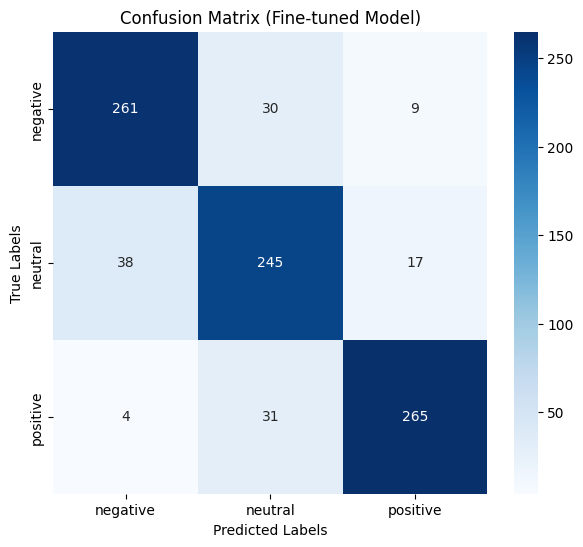

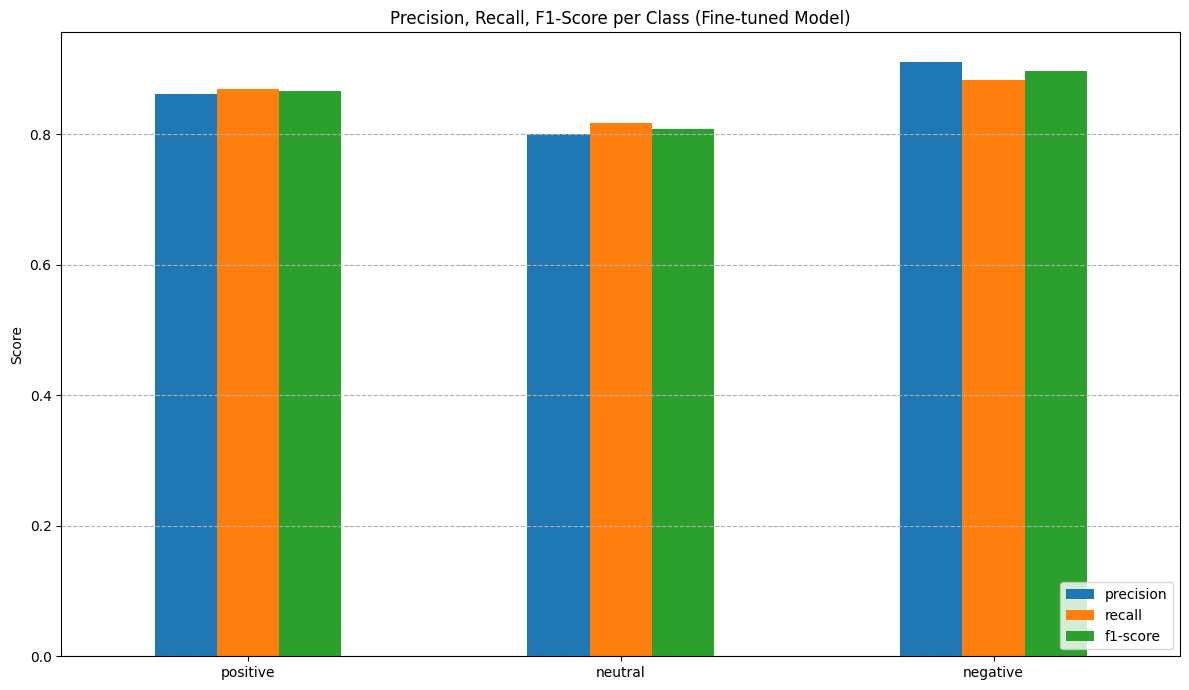

In [ ]:
filename_data = "/content/drive/MyDrive/FT/FineTuningData/data.csv" # Veri setinin Drive'daki yolu
df_full = pd.read_csv(filename_data, encoding="utf-8", encoding_errors="replace")
df_full.columns = ["text", "sentiment"]

temp_X_test_list = []
for sentiment_class in ["positive", "neutral", "negative"]:
    # df_full'dan bu sınıfa ait verileri al ve sadece test kısmını ayır
    _, test_split_data = train_test_split(df_full[df_full.sentiment==sentiment_class],
                                          train_size=300, # train_size'ı verdik, kalanı test olacak ama biz test_size=300 istiyoruz
                                          test_size=300,  # Bunu sağlamak için test_size'ı da belirt
                                          random_state=42,
                                          shuffle=True) # Karıştırma önemli
    temp_X_test_list.append(test_split_data)

X_test_original_df = pd.concat(temp_X_test_list).sample(frac=1, random_state=10).reset_index(drop=True)
y_true_labels = X_test_original_df.sentiment

def generate_test_prompt_local(data_point_text): # Fonksiyonu biraz değiştirdim, direkt metin alacak
    return f"""
Analyze the sentiment of the news headline enclosed in square brackets,
determine if it is positive, neutral, or negative, and return the answer as
the corresponding sentiment label "positive" or "neutral" or "negative".

[{data_point_text}] = """.strip()

X_test_prompts_df = pd.DataFrame(
    X_test_original_df["text"].apply(generate_test_prompt_local),
    columns=["text"]
)
print(f"\nTest için prompt'lar oluşturuldu. Örnek: {X_test_prompts_df.iloc[0]['text']}")

def predict_local(prompts_df, model_to_use, tokenizer_to_use):
    y_pred_list = []
    print("\nTest seti üzerinde tahminler yapılıyor...")
    sentiment_pipeline_local = pipeline(
        "text-generation",
        model=model_to_use,
        tokenizer=tokenizer_to_use
        # device otomatik olarak modelin yüklendiği cihaz olacak
    )
    for i in tqdm(range(len(prompts_df))):
        prompt = prompts_df.iloc[i]["text"]
        try:
            result = sentiment_pipeline_local(prompt, max_new_tokens=15, do_sample=False, pad_token_id=tokenizer_to_use.eos_token_id)
            generated_text_full = result[0]['generated_text']

            answer_part = generated_text_full[len(prompt):] if generated_text_full.startswith(prompt) else (generated_text_full.split("=")[-1] if "=" in generated_text_full else generated_text_full.split()[-1] if generated_text_full.split() else "")
            predicted_sentiment_raw = answer_part.strip().lower()

            final_sentiment = "unknown"
            if "positive" in predicted_sentiment_raw:
                final_sentiment = "positive"
            elif "negative" in predicted_sentiment_raw:
                final_sentiment = "negative"
            elif "neutral" in predicted_sentiment_raw:
                final_sentiment = "neutral"
            y_pred_list.append(final_sentiment)
        except Exception as e_pipe:
            print(f"Pipeline hatası (prompt {i}): {e_pipe}")
            y_pred_list.append("error") # Hata durumunda bir etiket ata
    return y_pred_list

# Tahminleri yap
y_pred_final = predict_local(X_test_prompts_df, model_finetuned, tokenizer_finetuned)

def evaluate_local(true_labels, pred_labels):
    labels_map_values = ['positive', 'neutral', 'negative']
    mapping_eval = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0, 'unknown': 1, 'error': 1} # Hata durumlarını da map'le
    def map_func_eval(x):
        return mapping_eval.get(x, 1)

    true_labels_mapped = np.vectorize(map_func_eval)(true_labels)
    pred_labels_mapped = np.vectorize(map_func_eval)(pred_labels)

    class_labels_report = ['negative', 'neutral', 'positive'] # confusion matrix için sıralama

    accuracy = accuracy_score(y_true=true_labels_mapped, y_pred=pred_labels_mapped)
    print(f"\nAccuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    # Ensure target_names matches the unique labels present and their order for confusion matrix
    # unique_sorted_labels_in_data = sorted(list(set(true_labels_mapped) | set(pred_labels_mapped)))
    # report_target_names = [class_labels_report[i] for i in unique_sorted_labels_in_data if i < len(class_labels_report)]
    # print(classification_report(true_labels_mapped, pred_labels_mapped, labels=unique_sorted_labels_in_data, target_names=report_target_names, zero_division=0))

    print(classification_report(true_labels, pred_labels, labels=labels_map_values, zero_division=0))


    conf_matrix = confusion_matrix(y_true=true_labels_mapped, y_pred=pred_labels_mapped, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

    plt.figure(figsize=(7, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels_report, yticklabels=class_labels_report)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix (Fine-tuned Model)')
    plt.show()

    report_dict_eval = classification_report(true_labels, pred_labels, target_names=labels_map_values, output_dict=True, zero_division=0)
    report_df_eval = pd.DataFrame(report_dict_eval).transpose()
    class_metrics_df_eval = report_df_eval.loc[labels_map_values]
    class_metrics_df_eval[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 7))
    plt.title('Precision, Recall, F1-Score per Class (Fine-tuned Model)')
    plt.ylabel('Score')
    plt.xticks(rotation=0)
    plt.legend(loc='lower right')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

evaluate_local(y_true_labels, y_pred_final)

# ***Eğitim Loglarının Manuel Gösterimi***

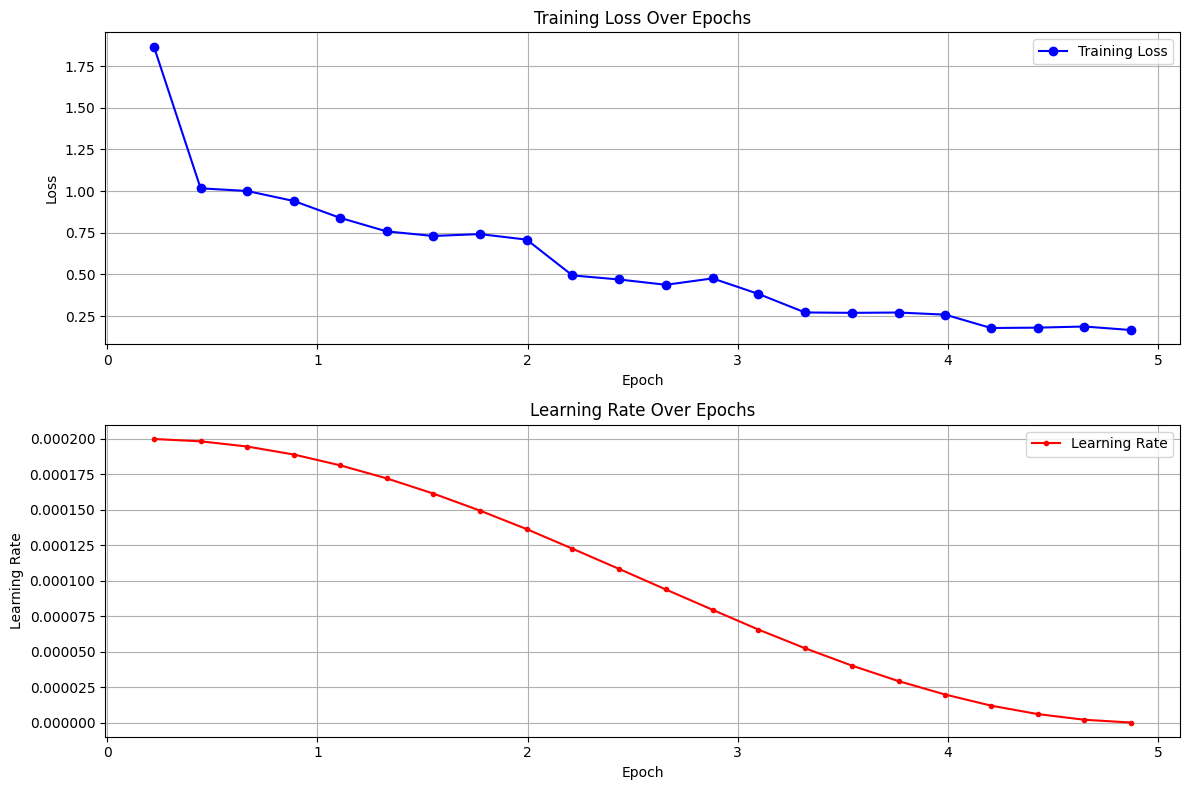

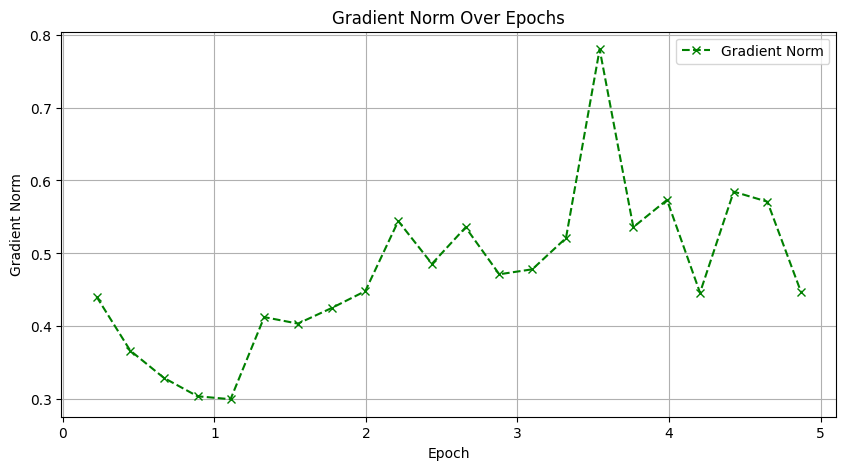

In [ ]:
import ast # String'den sözlük üretmek için
import matplotlib.pyplot as plt

# Son Eğitimden kalan log verileri
log_data_string = """
{'loss': 1.8673, 'grad_norm': 0.4407947063446045, 'learning_rate': 0.00019991800132985804, 'epoch': 0.2222222222222222}
{'loss': 1.0167, 'grad_norm': 0.3668549060821533, 'learning_rate': 0.0001982910507157424, 'epoch': 0.4444444444444444}
{'loss': 1.0006, 'grad_norm': 0.32934415340423584, 'learning_rate': 0.00019461134662200668, 'epoch': 0.6666666666666666}
{'loss': 0.9403, 'grad_norm': 0.30412065982818604, 'learning_rate': 0.00018895573760533413, 'epoch': 0.8888888888888888}
{'loss': 0.8402, 'grad_norm': 0.3000588119029999, 'learning_rate': 0.0001814423378887777, 'epoch': 1.1066666666666667}
{'loss': 0.7585, 'grad_norm': 0.41265541315078735, 'learning_rate': 0.0001722280606124415, 'epoch': 1.3288888888888888}
{'loss': 0.7309, 'grad_norm': 0.4037397801876068, 'learning_rate': 0.00016150534079053527, 'epoch': 1.551111111111111}
{'loss': 0.7422, 'grad_norm': 0.42505717277526855, 'learning_rate': 0.0001494981164140067, 'epoch': 1.7733333333333334}
{'loss': 0.7089, 'grad_norm': 0.4482440948486328, 'learning_rate': 0.00013645715163116846, 'epoch': 1.9955555555555555}
{'loss': 0.4942, 'grad_norm': 0.5443528890609741, 'learning_rate': 0.00012265479967907159, 'epoch': 2.2133333333333334}
{'loss': 0.4698, 'grad_norm': 0.4857324957847595, 'learning_rate': 0.00010837931493886562, 'epoch': 2.4355555555555557}
{'loss': 0.4381, 'grad_norm': 0.5357716679573059, 'learning_rate': 9.392883290468083e-05, 'epoch': 2.6577777777777776}
{'loss': 0.4763, 'grad_norm': 0.47139838337898254, 'learning_rate': 7.960514379100632e-05, 'epoch': 2.88}
{'loss': 0.3834, 'grad_norm': 0.47822853922843933, 'learning_rate': 6.570738981328266e-05, 'epoch': 3.097777777777778}
{'loss': 0.2721, 'grad_norm': 0.5210769772529602, 'learning_rate': 5.2525817770470084e-05, 'epoch': 3.32}
{'loss': 0.2698, 'grad_norm': 0.7800132632255554, 'learning_rate': 4.0335717403401576e-05, 'epoch': 3.542222222222222}
{'loss': 0.2717, 'grad_norm': 0.5360248684883118, 'learning_rate': 2.93916721229086e-05, 'epoch': 3.7644444444444445}
{'loss': 0.259, 'grad_norm': 0.5733652114868164, 'learning_rate': 1.9922242178037864e-05, 'epoch': 3.986666666666667}
{'loss': 0.1788, 'grad_norm': 0.4461233913898468, 'learning_rate': 1.2125191303410221e-05, 'epoch': 4.204444444444444}
{'loss': 0.181, 'grad_norm': 0.5846884846687317, 'learning_rate': 6.163356534514808e-06, 'epoch': 4.426666666666667}
{'loss': 0.1878, 'grad_norm': 0.5709354877471924, 'learning_rate': 2.161247447530268e-06, 'epoch': 4.648888888888889}
{'loss': 0.1666, 'grad_norm': 0.44698330760002136, 'learning_rate': 2.0244584664229628e-07, 'epoch': 4.871111111111111}
"""

# String'i satırlara böl ve her satırı bir sözlüğe dönüştür
parsed_logs = []
for line in log_data_string.strip().split('\n'):
    try:
        # ast.literal_eval, string'i güvenli bir şekilde Python nesnesine (sözlük) dönüştürür
        log_entry = ast.literal_eval(line)
        parsed_logs.append(log_entry)
    except ValueError as e:
        print(f"Satır işlenirken hata: {line} - Hata: {e}")


if parsed_logs:
    epochs = [log.get('epoch') for log in parsed_logs if 'loss' in log and 'epoch' in log]
    losses = [log.get('loss') for log in parsed_logs if 'loss' in log and 'epoch' in log]
    learning_rates = [log.get('learning_rate') for log in parsed_logs if 'learning_rate' in log and 'epoch' in log]
    grad_norms = [log.get('grad_norm') for log in parsed_logs if 'grad_norm' in log and 'epoch' in log]


    if epochs and losses:
        plt.figure(figsize=(12, 8))

        # Loss vs Epoch
        plt.subplot(2, 1, 1) # 2 satır, 1 sütun, 1. grafik
        plt.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Training Loss')
        plt.title('Training Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Learning Rate vs Epoch
        if learning_rates and len(learning_rates) == len(epochs):
            plt.subplot(2, 1, 2) # 2 satır, 1 sütun, 2. grafik
            plt.plot(epochs, learning_rates, marker='.', linestyle='-', color='r', label='Learning Rate')
            plt.title('Learning Rate Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Learning Rate')
            plt.legend()
            plt.grid(True)

        plt.tight_layout()
        plt.show()

        # Gradient Norm vs Epoch
        if grad_norms and len(grad_norms) == len(epochs):
            plt.figure(figsize=(10, 5))
            plt.plot(epochs, grad_norms, marker='x', linestyle='--', color='g', label='Gradient Norm')
            plt.title('Gradient Norm Over Epochs')
            plt.xlabel('Epoch')
            plt.ylabel('Gradient Norm')
            plt.legend()
            plt.grid(True)
            plt.show()

    else:
        print("Grafik çizmek için yeterli epoch veya loss bilgisi loglarda bulunamadı.")
else:
    print("Log verisi işlenemedi.")

# ***Finansal jargon ile test***

In [ ]:
if 'model_finetuned' in locals() and 'tokenizer_finetuned' in locals():
    print("Fine-tune edilmiş model ve tokenizer test için hazır.\n")

    # Pipeline'ı oluştur (eğer daha önce oluşturulmadıysa veya farklı bir modelle ise)
    if 'sentiment_pipeline_local' not in locals() or sentiment_pipeline_local.model is not model_finetuned:
        print("Test için pipeline oluşturuluyor...")
        sentiment_pipeline_local = pipeline(
            "text-generation",
            model=model_finetuned,
            tokenizer=tokenizer_finetuned
            # device otomatik olarak modelin yüklendiği cihaz olacak
        )
        print("Pipeline oluşturuldu.")

    # Test edilecek FİNANSAL örnek cümleler
    financial_sample_sentences = [
        "The company's quarterly earnings exceeded all analyst expectations, sending a strong positive signal to the market.", # Beklenen: positive
        "Due to rising inflation and supply chain disruptions, XYZ Corp issued a profit warning for the next fiscal year.", # Beklenen: negative
        "The central bank announced it would maintain current interest rates, a move largely anticipated by investors.",     # Beklenen: neutral
        "Tech stocks rallied today after the Federal Reserve hinted at a more dovish monetary policy.",                 # Beklenen: positive
        "Shareholders expressed deep concerns over the recent decline in the company's market share and revenue.",        # Beklenen: negative
        "The upcoming IPO is expected to be one of the largest this year, though market conditions remain volatile.",   # Beklenen: neutral (veya duruma göre pozitif/negatif olabilir, modelin yorumuna bağlı)
        "ABC Inc. successfully launched its new product line, which is projected to significantly boost sales.",      # Beklenen: positive
        "Regulatory hurdles and increased competition are posing significant challenges for the firm's expansion plans.", # Beklenen: negative
        "The latest jobs report showed steady employment figures, in line with previous months.",                   # Beklenen: neutral
        "$TSLA stock surged by 10% following Elon Musk's optimistic a"                                                # Beklenen: positive
    ]

    # Prompt oluşturma fonksiyonu (önceki hücrelerden alıntı)
    def generate_test_prompt_for_financial_samples(text_input):
        return f"""
Analyze the sentiment of the news headline enclosed in square brackets,
determine if it is positive, neutral, or negative, and return the answer as
the corresponding sentiment label "positive" or "neutral" or "negative".

[{text_input}] = """.strip()

    print("\n--- Finansal Örnek Cümleler ile Duygu Analizi Testi ---")
    for sentence in financial_sample_sentences:
        prompt = generate_test_prompt_for_financial_samples(sentence)

        try:
            result = sentiment_pipeline_local(
                prompt,
                max_new_tokens=15, # "negative", "positive", "neutral" için yeterli
                do_sample=False,   # Deterministik çıktı için
                pad_token_id=tokenizer_finetuned.eos_token_id # Padding için
            )

            generated_text_full = result[0]['generated_text']

            # Cevabı ayrıştır
            answer_part = ""
            if generated_text_full.startswith(prompt):
                answer_part = generated_text_full[len(prompt):]
            elif "=" in generated_text_full:
                answer_part = generated_text_full.split("=")[-1]
            else: # Model sadece etiketi ürettiyse (veya beklenmedik bir formatta)
                # Son kelimeyi veya birkaç kelimeyi almayı deneyebiliriz
                words_in_output = generated_text_full.split()
                if words_in_output:
                    answer_part = words_in_output[-1] # Son kelimeyi al
                    if len(words_in_output) > 1 and words_in_output[-2] == "=": # "= sentiment" formatı
                        answer_part = words_in_output[-1]

            predicted_sentiment_raw = answer_part.strip().lower().replace("\"", "").replace(".", "") # Tırnak ve noktaları da temizle

            final_sentiment = "unknown"
            # Etiketleri daha kesin yakalamak için tam eşleşme veya başlangıç kontrolü
            if predicted_sentiment_raw.startswith("positive"):
                final_sentiment = "positive"
            elif predicted_sentiment_raw.startswith("negative"):
                final_sentiment = "negative"
            elif predicted_sentiment_raw.startswith("neutral"):
                final_sentiment = "neutral"
            # Eğer model sadece tek kelime üretiyorsa ve bu kelimelerden biriyse:
            elif predicted_sentiment_raw in ["positive", "negative", "neutral"]:
                final_sentiment = predicted_sentiment_raw

            print(f"Cümle: '{sentence}'")
            # print(f"   Prompt: {prompt}") # İsteğe bağlı hata ayıklama
            # print(f"   Generated Text (Full): {generated_text_full}") # İsteğe bağlı hata ayıklama
            # print(f"   Answer Part (Raw): '{predicted_sentiment_raw}'") # İsteğe bağlı hata ayıklama
            print(f"   Model Tahmini: {final_sentiment}")
            print("-" * 40)

        except Exception as e_pipe:
            print(f"Cümle için pipeline hatası '{sentence}': {e_pipe}")
            print("-" * 40)
else:
    print("HATA: 'model_finetuned' veya 'tokenizer_finetuned' bulunamadı.")
    print("Lütfen modeli ve tokenizer'ı yüklediğinizden emin olun (bir önceki model yükleme hücresi).")

The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOcr2ForConditionalGeneration', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCa

Fine-tune edilmiş model ve tokenizer test için hazır.

Test için pipeline oluşturuluyor...
Pipeline oluşturuldu.

--- Finansal Örnek Cümleler ile Duygu Analizi Testi ---
Cümle: 'The company's quarterly earnings exceeded all analyst expectations, sending a strong positive signal to the market.'
   Model Tahmini: positive
----------------------------------------
Cümle: 'Due to rising inflation and supply chain disruptions, XYZ Corp issued a profit warning for the next fiscal year.'
   Model Tahmini: negative
----------------------------------------
Cümle: 'The central bank announced it would maintain current interest rates, a move largely anticipated by investors.'
   Model Tahmini: neutral
----------------------------------------
Cümle: 'Tech stocks rallied today after the Federal Reserve hinted at a more dovish monetary policy.'
   Model Tahmini: positive
----------------------------------------
Cümle: 'Shareholders expressed deep concerns over the recent decline in the company's marke

# ***Veri Setinden Örneklerle Test***

In [ ]:
if 'model_finetuned' in locals() and \
   'tokenizer_finetuned' in locals() and \
   'df_full' in locals() and \
   'generate_test_prompt_for_financial_samples' in locals() and \
   'sentiment_pipeline_local' in locals():

    print("Model, tokenizer, veri seti ve gerekli fonksiyonlar test için hazır.\n")

    num_samples_to_test = 10  # Test edilecek örnek sayısı
    if len(df_full) < num_samples_to_test:
        num_samples_to_test = len(df_full) # Eğer veri seti daha küçükse, tümünü kullan

    # Veri setinden rastgele örnekler seç
    sample_df = df_full.sample(n=num_samples_to_test, random_state=42) # Her seferinde aynı örnekleri seçmek için random_state

    print(f"--- Veri Setinden Rastgele {num_samples_to_test} Örnek ile Duygu Analizi Testi ---")
    for index, row in sample_df.iterrows():
        actual_sentence = row['text']
        actual_sentiment = row['sentiment']

        prompt = generate_test_prompt_for_financial_samples(actual_sentence) # Bir önceki hücredeki prompt fonksiyonu

        try:
            result = sentiment_pipeline_local(
                prompt,
                max_new_tokens=15,
                do_sample=False,
                pad_token_id=tokenizer_finetuned.eos_token_id
            )

            generated_text_full = result[0]['generated_text']

            answer_part = ""
            if generated_text_full.startswith(prompt):
                answer_part = generated_text_full[len(prompt):]
            elif "=" in generated_text_full:
                answer_part = generated_text_full.split("=")[-1]
            else:
                words_in_output = generated_text_full.split()
                if words_in_output:
                    answer_part = words_in_output[-1]
                    if len(words_in_output) > 1 and words_in_output[-2] == "=":
                        answer_part = words_in_output[-1]

            predicted_sentiment_raw = answer_part.strip().lower().replace("\"", "").replace(".", "")

            final_predicted_sentiment = "unknown"
            if predicted_sentiment_raw.startswith("positive"):
                final_predicted_sentiment = "positive"
            elif predicted_sentiment_raw.startswith("negative"):
                final_predicted_sentiment = "negative"
            elif predicted_sentiment_raw.startswith("neutral"):
                final_predicted_sentiment = "neutral"
            elif predicted_sentiment_raw in ["positive", "negative", "neutral"]:
                final_predicted_sentiment = predicted_sentiment_raw

            print(f"Cümle: '{actual_sentence}'")
            print(f"   Gerçek Duygu   : {actual_sentiment}")
            print(f"   Model Tahmini  : {final_predicted_sentiment} (Ham Çıktı: '{predicted_sentiment_raw[:30]}...')")
            if actual_sentiment.lower() == final_predicted_sentiment:
                print("   Sonuç          : DOĞRU")
            else:
                print(f"   Sonuç          : YANLIŞ (Beklenen: {actual_sentiment}, Tahmin: {final_predicted_sentiment})")
            print("-" * 50)

        except Exception as e_pipe:
            print(f"Cümle için pipeline hatası '{actual_sentence}': {e_pipe}")
            print("-" * 50)
else:
    print("HATA: Gerekli değişkenler (model_finetuned, tokenizer_finetuned, df_full, vb.) bulunamadı.")
    print("Lütfen önceki hücreleri doğru çalıştırdığınızdan emin olun.")

Model, tokenizer, veri seti ve gerekli fonksiyonlar test için hazır.

--- Veri Setinden Rastgele 10 Örnek ile Duygu Analizi Testi ---
Cümle: 'A few employees would remain at the Oulu plant in support functions for other group units .'
   Gerçek Duygu   : neutral
   Model Tahmini  : neutral (Ham Çıktı: 'neutral

[the company said tha...')
   Sonuç          : DOĞRU
--------------------------------------------------
Cümle: 'Comparable net sales are expected to increase more than 10 % in 2008 , in line with group target .'
   Gerçek Duygu   : positive
   Model Tahmini  : positive (Ham Çıktı: 'positive
[the company's order ...')
   Sonuç          : DOĞRU
--------------------------------------------------
Cümle: 'Tesla is recalling 2,700 Model X cars: https://t.co/8Z7BkVsTl9 $TSLA'
   Gerçek Duygu   : negative
   Model Tahmini  : negative (Ham Çıktı: 'negative
[the company's order ...')
   Sonuç          : DOĞRU
--------------------------------------------------
Cümle: 'Finnish software deve